## C'est quoi le K-NN :

l’algorithme K-NN (K-nearest neighbors) est une méthode d’apprentissage supervisé. Il peut être utilisé aussi bien pour la régression que pobur la classification.

Pour effectuer une prédiction, l’algorithme K-NN va se baser sur le jeu de données en entier. 
En effet, pour une observation, qui ne fait pas parti du jeu de données, qu’on souhaite prédire, l’algorithme va chercher les K instances du jeu de données les plus proches de notre observation. Ensuite pour ces K voisins, l’algorithme se basera sur leurs variables de sortie (output variable) y pour calculer la valeur de la variable y de l’observation qu’on souhaite prédire. 

* Si K-NN est utilisé pour la régression, c’est la moyenne des variables y des K-NN qui servira pour la prédiction
* Si K-NN est utilisé pour la classification, c’est le mode des variables y des K-NN qui servira pour la prédiction

## Ecriture algorithmique de K-NN

Début Algorithme

    Données en entrée :

    - un ensemble de données D .
    - une fonction de définition distance d.
    - un nombre entier K

    **Pour une nouvelle observation X dont on veut prédire sa variable de sortie y Faire :

    1- Calculer toutes les distances de cette observation X avec les autres observations du jeu de données D
    2- Retenir les K observations du jeu de données D les proches de X en utilisation le fonction de calcul de distance d
    3- Prendre les valeurs de y des K observations retenues :
        - Si on effectue une régression, calculer la moyenne (ou la médiane) de y retenues
        - Si on effectue une classification , calculer le mode de y retenues
          (le mode = valeur dominante, la valeur la plus représentée d'une variable quelconque dans une population donnée)
    4- Retourner la valeur calculée dans l’étape 3 comme étant la valeur qui a été prédite par K-NN pour l’observation X.
Fin Algorithme

# Application du K-NN : Classification de patients souffrant d’un cancer.

## 1- Importation du jeu de données : 

In [1]:
import pandas as pd
import seaborn as sns
# Importing Statements
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np

In [2]:
df = pd.read_csv('data.csv',sep=",")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Mapping Benign to 0 and Malignant to 1 
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Le dataset a été créé dans le but de prédire si les cellules cancéreuses sont bénignes ou malignes.


## 2- Visualusation des données : 

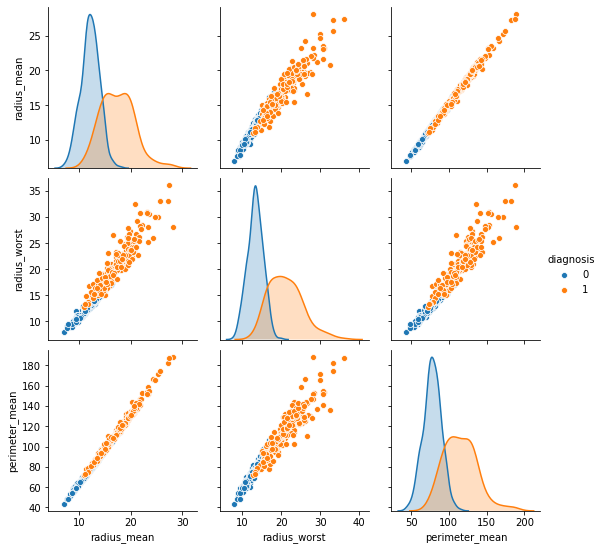

In [3]:
sns.pairplot(df, hue = 'diagnosis', vars = ['radius_mean', 'radius_worst', 'perimeter_mean'])

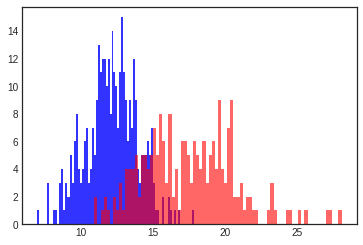

In [4]:
dataMalignant=df[df['diagnosis'] ==1]
dataBenign=df[df['diagnosis'] ==0]

plt.style.use('seaborn-white')
plt.hist(dataBenign['radius_mean'], bins=80,alpha=0.8, color='Blue', label='B') 
plt.hist(dataMalignant['radius_mean'], bins=80,alpha=0.6, color='red', label='M')
plt.show()

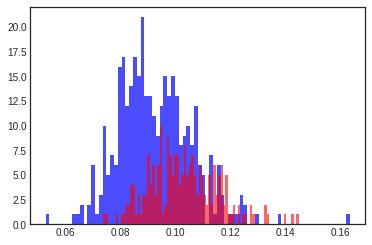

In [5]:
plt.style.use('seaborn-white')
plt.hist(dataBenign['smoothness_mean'], bins=80,alpha=0.7, color='Blue', label='B') 
plt.hist(dataMalignant['smoothness_mean'], bins=80, alpha=0.6,color='red', label='M')
plt.show()

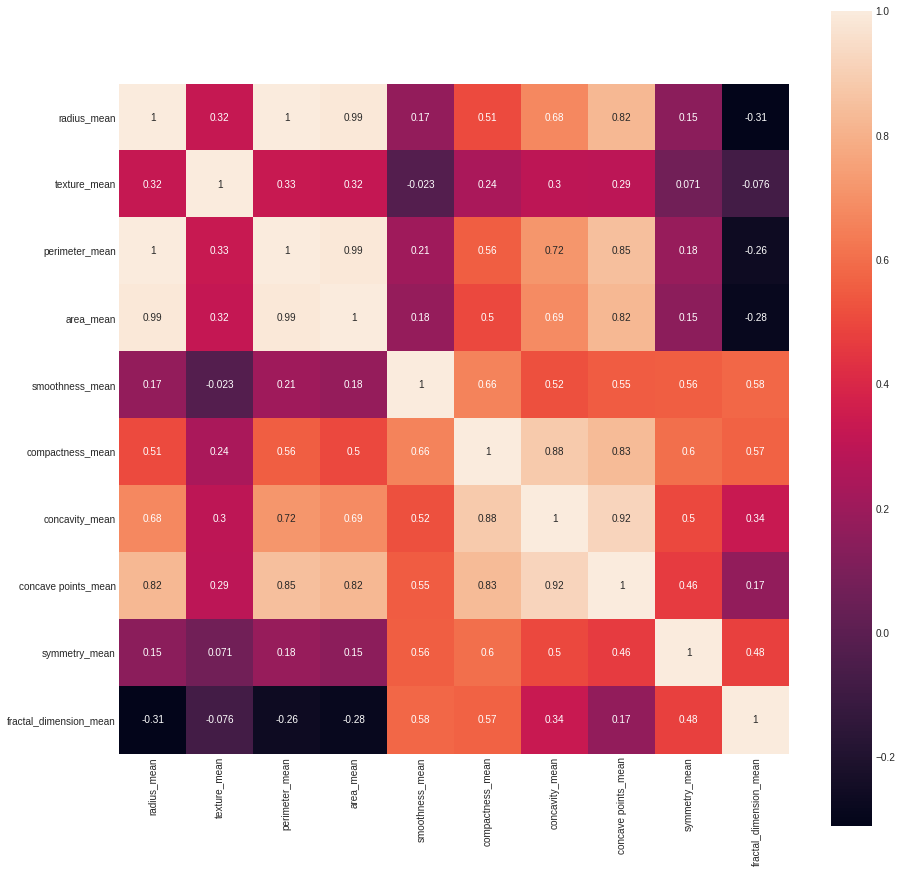

In [6]:
# Matrice de correlation
features_mean = ['radius_mean','texture_mean','perimeter_mean','area_mean','smoothness_mean', 'compactness_mean', 'concavity_mean','concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
plt.figure(figsize=(15,15))
heat = sns.heatmap(df[features_mean].corr(), vmax=1, square=True, annot=True)

## 3- Déclarer le vecteur de caractéristiques et la variable cible


In [7]:
df = pd.read_csv('data.csv',sep=",")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Mapping Benign to 0 and Malignant to 1 
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})

target =  df.diagnosis
features = df.drop('diagnosis',axis=1)
features = features.drop('id',axis=1)

## 4-Feature engineering (Ingénierie des fonctionnalités) :  

### a- Recursive Feature Elimination 

La méthode Recursive Feature Elimination (RFE) est une approche de sélection de caractéristiques. Il fonctionne en supprimant récursivement les attributs et en construisant un modèle sur les attributs qui restent. Il utilise la précision du modèle pour identifier les attributs (et la combinaison d'attributs) qui contribuent le plus à la prédiction de l'attribut cible.

In [8]:
#Ignore some Warnings and exceptions 

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# ignore ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#define a classifier
model = LogisticRegression()

#create RFE model to return top 3 attributes
rfe = RFE(model,3)
rfe = rfe.fit(features,target)

#summarise the selection of attributes
print(rfe.support_)
print(rfe.ranking_)
# print(features.columns.values)

[False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False  True  True False False]
[ 4 17 16 26 10  7  1  6  8 25 13  5 14 12 28 21 20 23 24 27 18 11 15 22
 19  2  1  1  3  9]


So according to feature importance method, top 3 features are  :
- concavity_mean
- concavity_worst
- concave points_worst

### b- Feature importance ranking

In [11]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

#define and fit a ExtraTreeClassifier to the data
model = ExtraTreesClassifier()
model.fit(features,target)

#display the feature importance
print(model.feature_importances_)
#print('\n',features.columns.values)

[0.05381995 0.01327318 0.07299241 0.04062169 0.01227681 0.0211187
 0.06881275 0.07287972 0.0080115  0.00846159 0.03391086 0.00506169
 0.02416781 0.0292102  0.00642383 0.00690927 0.00626592 0.0095631
 0.00532365 0.00641433 0.08186809 0.0265915  0.08980619 0.06864717
 0.02037585 0.02760211 0.0426368  0.10902778 0.01902862 0.00889693]


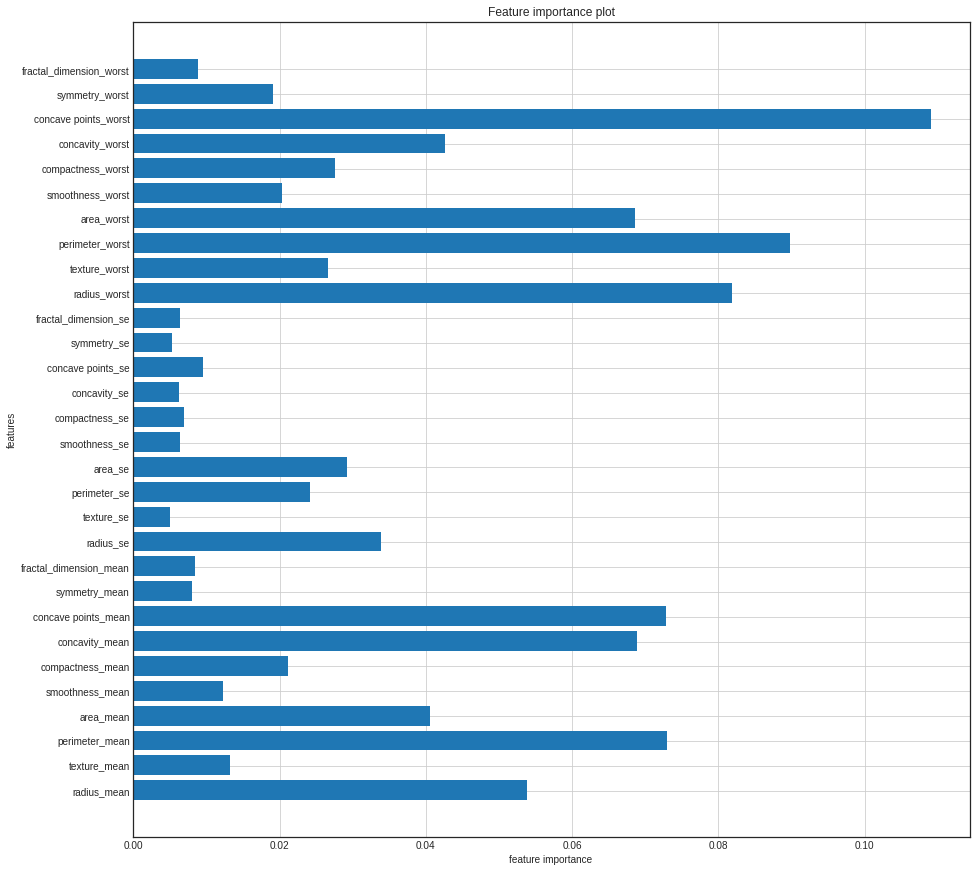

In [12]:
#bar plot of feature importance
plt.figure(figsize=(15,15))
values = model.feature_importances_
pos = np.arange(30) + 0.02
plt.barh(pos,values,align = 'center')
plt.title('Feature importance plot')
plt.xlabel('feature importance ')
plt.ylabel('features')
plt.yticks(np.arange(30),('radius_mean', 'texture_mean' ,'perimeter_mean' ,'area_mean',
 'smoothness_mean' ,'compactness_mean', 'concavity_mean',
 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
 'radius_se' ,'texture_se' ,'perimeter_se', 'area_se' ,'smoothness_se',
 'compactness_se', 'concavity_se' ,'concave points_se', 'symmetry_se',
 'fractal_dimension_se' ,'radius_worst' ,'texture_worst' ,'perimeter_worst',
 'area_worst', 'smoothness_worst' ,'compactness_worst', 'concavity_worst',
 'concave points_worst', 'symmetry_worst' ,'fractal_dimension_worst'))
plt.grid(True)

So according to feature importance method, top 3 features are  :
- concave_points_worst
- area_worst
- perimeter_worst

## 5- Features scaling and visualizing :

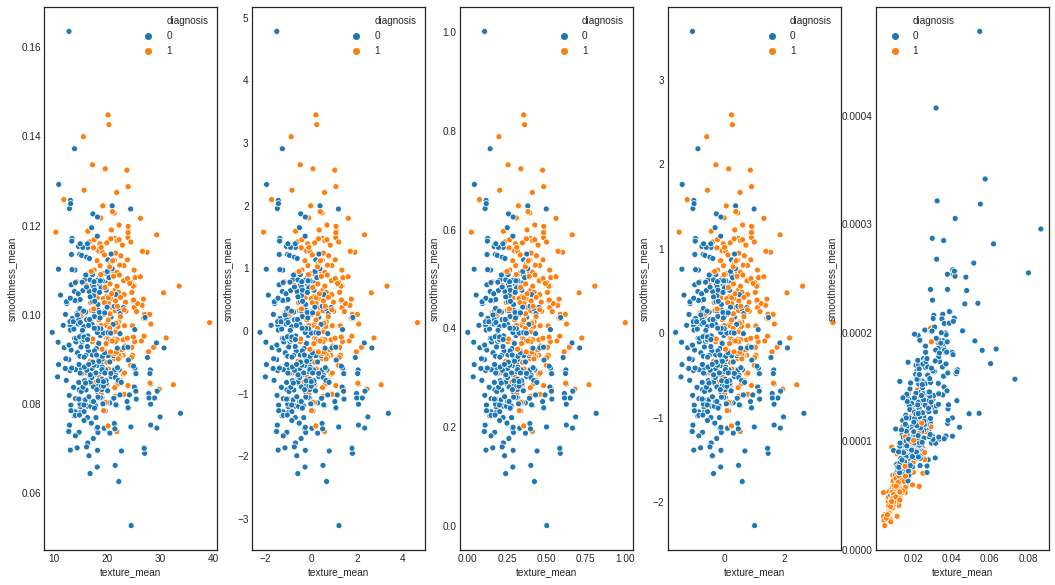

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer

standard_scaled_features = StandardScaler().fit_transform(features.values)
scaled_features_df = pd.DataFrame(standard_scaled_features, index=features.index, columns=features.columns)

MinMax_scaled_features = MinMaxScaler().fit_transform(features.values)
MinMax_features_df = pd.DataFrame(MinMax_scaled_features, index=features.index, columns=features.columns)


RobustScaler_scaled_features = RobustScaler().fit_transform(features.values)
RobustScaler_features_df = pd.DataFrame(RobustScaler_scaled_features, index=features.index, columns=features.columns)

Nomalized_features = Normalizer().fit_transform(features.values)
Nomalized_features_df = pd.DataFrame(Nomalized_features, index=features.index, columns=features.columns)

fig, ax =plt.subplots(1,5, figsize=(18,10))
sns.scatterplot(x = features['texture_mean'], y = features['smoothness_mean'], hue = target, ax=ax[0])
sns.scatterplot(x = scaled_features_df['texture_mean'], y = scaled_features_df['smoothness_mean'], hue = target, ax=ax[1])
sns.scatterplot(x = MinMax_features_df['texture_mean'], y = MinMax_features_df['smoothness_mean'], hue = target, ax=ax[2])
sns.scatterplot(x = RobustScaler_features_df['texture_mean'], y = RobustScaler_features_df['smoothness_mean'], hue = target, ax=ax[3])
sns.scatterplot(x = Nomalized_features_df['texture_mean'], y = Nomalized_features_df['smoothness_mean'], hue = target, ax=ax[4])


## - Reconstruire le modèle de classification kNN en utilisant différentes valeurs de k

* on va construire notre model KNN
    - on se basant dans un prmeier temps sur les données brut
    - puis sur les données normalisées 
    - et enfin sur les données standardisées
* on va tester plusieur valeurs de k (nombre de voisins) et voir l'influence des différentes valeurs de k sur les scores et l'accuracy du model
* pour plus de précision et d'exactitude, on va calculer les scores avec la cross validation

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,KFold,cross_val_score

In [15]:
def accuracy_variation(features,target):

    #spliting data into train and test data
    X_train,X_test,y_train,y_test = train_test_split(features,target)
    
    std_X_train = StandardScaler().fit_transform(X_train)
    std_X_test = StandardScaler().fit_transform (X_test)
    std_features = StandardScaler().fit_transform (features)
    
    MinMax_X_train = MinMaxScaler().fit_transform(X_train)
    MinMax_X_test = MinMaxScaler().fit_transform (X_test)
    MinMax_features = MinMaxScaler().fit_transform (features)
    
    Rb_X_train = RobustScaler().fit_transform(X_train)
    Rb_X_test = RobustScaler().fit_transform (X_test)
    Rb_features = RobustScaler().fit_transform (features)
    
    Nrm_X_train = Normalizer().fit_transform(X_train)
    Nrm_X_test = Normalizer().fit_transform (X_test)
    Nrm_features = Normalizer().fit_transform (features)
    
    k_values = np.arange(1,25)
    scores = []
    std_scores = []
    MinMax_scores = []
    Rb_scores = []
    Nrm_scores = []

    for i in k_values:
        clf = KNeighborsClassifier(n_neighbors=i)
        clf.fit(X_train,y_train)
        scores_ = cross_val_score(clf, features, target, cv=5)
        scores.append(np.mean(scores_))
        
        clf1 = KNeighborsClassifier(n_neighbors=i)
        clf1.fit(std_X_train,y_train)
        scores_ = cross_val_score(clf1, std_features, target, cv=5)
        std_scores.append(np.mean(scores_))
        
        clf2 = KNeighborsClassifier(n_neighbors=i)
        clf2.fit(MinMax_X_train,y_train)
        scores_ = cross_val_score(clf2, MinMax_features, target, cv=5)
        MinMax_scores.append(np.mean(scores_))
         
        clf3 = KNeighborsClassifier(n_neighbors=i)
        clf3.fit(Rb_X_train,y_train)
        scores_ = cross_val_score(clf3, Rb_features, target, cv=5)
        Rb_scores.append(np.mean(scores_))
        
        clf4 = KNeighborsClassifier(n_neighbors=i)
        clf4.fit(Nrm_X_train,y_train)
        scores_ = cross_val_score(clf4, Nrm_features, target, cv=5)
        Nrm_scores.append(np.mean(scores_))
        
        
    print("Accuracy for {} neighbors is {}".format(np.argmax(scores)+1,round(max(scores),2)))
    print("Standard scaled data :  Accuracy for {} neighbors is {}".format(np.argmax(std_scores)+1,round(max(std_scores),2)))
    print("MinMax scaled data:  Accuracy for {} neighbors is {}".format(np.argmax(MinMax_scores)+1,round(max(MinMax_scores),2)))
    print("Robuste scaled data :  Accuracy for {} neighbors is {}".format(np.argmax(Rb_scores)+1,round(max(Rb_scores),2)))
    print("Normalized data : Accuracy for {} neighbors is {}".format(np.argmax(Nrm_scores)+1,round(max(Nrm_scores),2)))
    
    plt.figure(figsize=(20,10))
    plt.plot(k_values,scores,linestyle='dashed', label="Données Brut")
    plt.plot(k_values,std_scores,linestyle='dotted', label="Standard_Scaler",linewidth=4)
    plt.plot(k_values,MinMax_scores, label="MinMax_Scaler",linewidth=4)
    plt.plot(k_values,Rb_scores, label="Robust_scaler",linewidth=4)
    plt.plot(k_values,Nrm_scores, label="Normalisation")
    plt.title('Varition of accuracy with K value,including all features')
    plt.xlabel('K values')
    plt.xticks(k_values)

    plt.ylabel('Accuracy')
    plt.legend()

    return

Accuracy for 14 neighbors is 0.94
Standard scaled data :  Accuracy for 9 neighbors is 0.97
MinMax scaled data:  Accuracy for 6 neighbors is 0.97
Robuste scaled data :  Accuracy for 7 neighbors is 0.97
Normalized data : Accuracy for 6 neighbors is 0.93


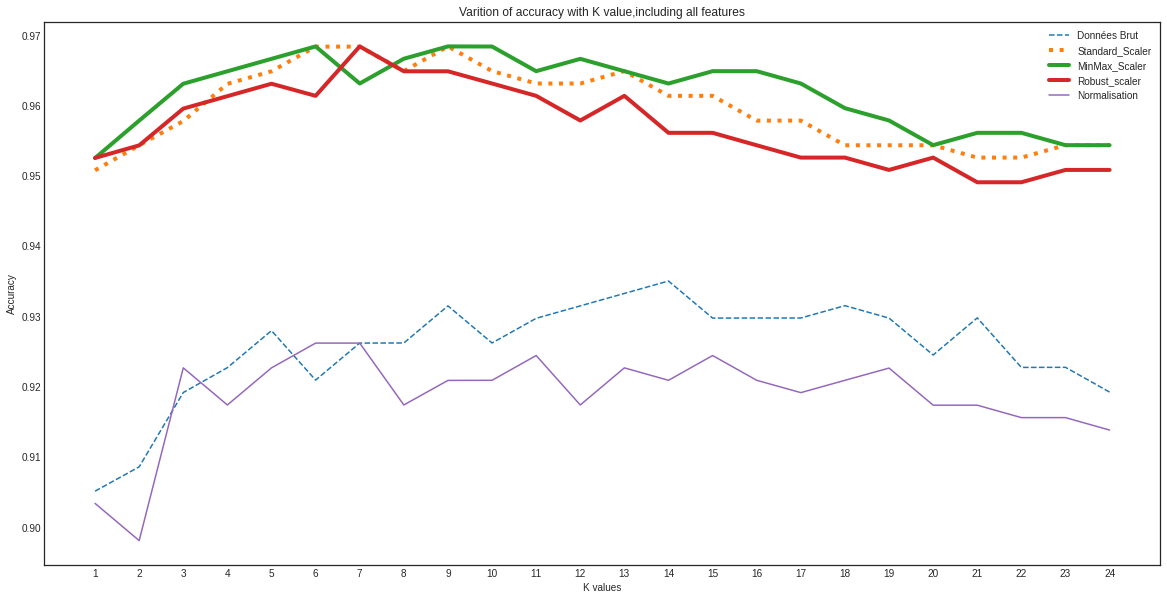

In [16]:
accuracy_variation(features,target)

- Standard scaled data :  Accuracy for 9 neighbors is 0.97
- MinMax scaled data:  Accuracy for 6 neighbors is 0.97
- Robuste scaled data :  Accuracy for 7 neighbors is 0.97
- Normalized data : Accuracy for 6 neighbors is 0.93
- Not scaled data : Accuracy for 14 neighbors is 0.94

Conclusion : 

* Based on the analysis we did and the results we get, we can say that to get better accuracy we have to scale our data using one of {Standard_Scaler, MimMax_scaler, Robuste_Scaler}

* From the previous graph, we can conclude that it's not recommanded to use normalization to our case of data

### 7- KNN model (k=9, Standard Scaled data) 

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

'''
! just for Reminding : 

standard_scaled_features = StandardScaler().fit_transform(features.values)
scaled_features_df = pd.DataFrame(standard_scaled_features, index=features.index, columns=features.columns)

'''
#spliting data into train and test data
X_train,X_test,y_train,y_test = train_test_split(scaled_features_df,target)

In [23]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_train,y_train)
y_predict = clf.predict(X_test)

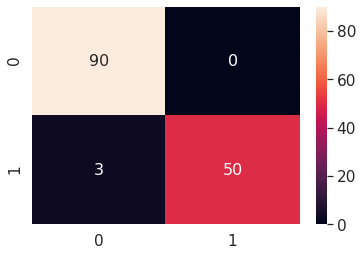

In [24]:
cf =confusion_matrix(y_test, y_predict)

df_cf = pd.DataFrame(cf, range(2),range(2))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cf, annot=True, annot_kws={"size": 16}) # font size
plt.show()

Interpretations : 
- 88 True benign predicted
- 4 False benign predicted
- 51 True Malign predicted
- 0 False Malign predicted

In [25]:
#Classification report
target_names = ['Benignant', 'Malignant']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

   Benignant       0.97      1.00      0.98        90
   Malignant       1.00      0.94      0.97        53

    accuracy                           0.98       143
   macro avg       0.98      0.97      0.98       143
weighted avg       0.98      0.98      0.98       143



## 8- Courbe ROC (Receiver Operating Characteristic) : 

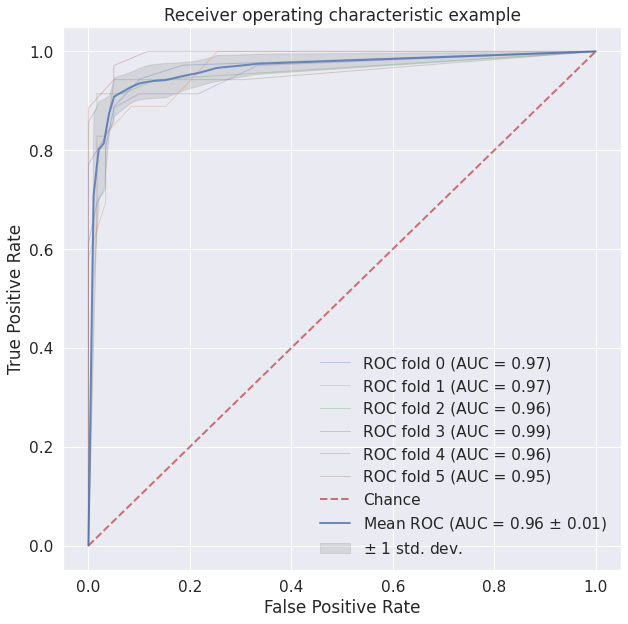

In [27]:
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################

X = features
y = target
n_samples, n_features = X.shape

X = np.c_[X]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = KNeighborsClassifier(n_neighbors=9)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize=(10,10))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',  label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,  label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],  title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

on constate que la courbe ROC monte rapidement de 0 vers 1, c'est à dire que sur nos préduction, ona a un True Positive Rate est plus important que le False Positive Rate.